IRD stream
=======================

By using the framework of ``Stream2D``, you can apply functions into multiple fits files.
Here, we try to reduce from raw data to wavelength calibrated spectra.

Start by setting a path for the directory which contains raw data of 'Flat', 'ThAr', and 'Target' (and 'Dark', optionally).

In [1]:
import pathlib
basedir = pathlib.Path('~/pyird/data/20210317/').expanduser()

## Preprocessing of calibration dataset

Set the directory and frame numbers for 'Flat'
to search for reference apertures for spectrum extraction.

* It would be better to use FLAT_COMB data (flat light injected to the LFC fiber)
  because lights can be found in both fibers so that there is no need to change frame IDs when switching fiber to analyze.
* Frame numbers can be set the even numbers. When analyzing H band, they are increased by one by using ``fitsid_increment()``.

In [2]:
from pyird.utils import irdstream
### FOR CALIBRATION ###
# aperture extraction
datadir = basedir/'flat/'
anadir = basedir/'reduc/'
flat=irdstream.Stream2D("flat",datadir,anadir)
flat.fitsid=list(range(41704,41804,2)) ##FLAT_COMB

No fitsid yet.


Then, select the band to analyze ('y' for YJ band or 'h' for H band).

In [3]:
flat.band='h' #'h' or 'y'
print(flat.band,' band')

h  band


The function `aptrace` searches apertures to be traced.

* The number of apertures is specified by ``nap``,
  which should be set 42 (or 21) for H band and 102 (or 51) for YJ band.
* The apertures begin its search at ``cutrow``, which is the row number of the detector (wavelength direction),
  and continue in the direction of increasing numbers until it matches the appropriate number of apertures.
  You may as well change the value of ``cutrow`` if the aperture trace is failed.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 336.90it/s]


cross-section: row  1170


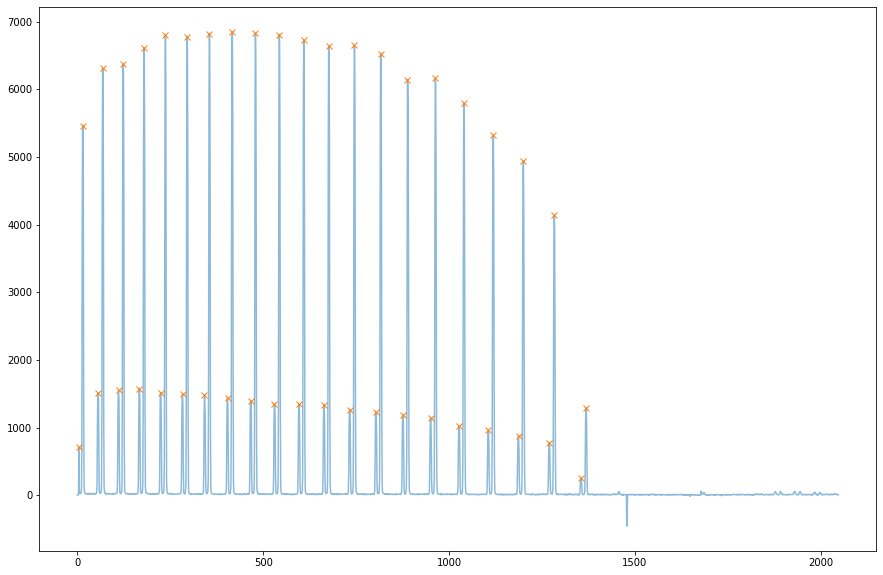

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:12<00:00,  3.46it/s]


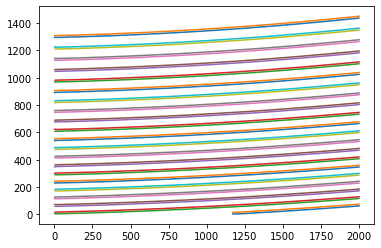

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 103.88it/s]


In [4]:
if flat.band=='h':
    flat.fitsid_increment() # when you use H-band
    trace_mmf=flat.aptrace(cutrow = 800,nap=42) #TraceAperture instance
elif flat.band=='y':
    trace_mmf=flat.aptrace(cutrow = 1000,nap=102) #TraceAperture instance
trace_mask = trace_mmf.mask()

Show trace mask.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 105.77it/s]


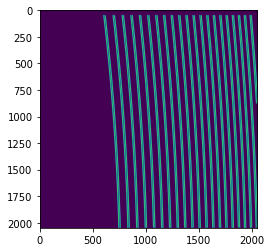

In [5]:
import matplotlib.pyplot as plt
plt.imshow(trace_mmf.mask()) #apeture mask plot
plt.show()

There are two options for the hotpixel mask:

One is made from dark data as follows.

In [6]:
from pyird.image.bias import bias_subtract_image
from pyird.image.hotpix import identify_hotpix_sigclip

# hotpixel mask: See pyird/io/read_hotpix.py for reading fixed mask (Optional)
datadir = basedir/'dark/'
anadir = basedir/'reduc/'
dark = irdstream.Stream2D('dark', datadir, anadir,fitsid=[43814]) # Multiple file is ok
if flat.band=='h':
    dark.fitsid_increment() # when you use H-band
median_image = dark.immedian()
im_subbias = bias_subtract_image(median_image)
hotpix_mask = identify_hotpix_sigclip(im_subbias)

fitsid: [41504]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 80.91it/s]


hotpix mask = 0.58 percent


Another option is reading the prepared hotpixel mask as follows.

In [7]:
# example to read a hotpixel mask used in IRD
import pkg_resources
from pyird.io.read_hotpix import read_hotpix
if flat.band=='h':
    path=pkg_resources.resource_filename('pyird', 'data/hotpix_mask_h_202210_180s.fits')
elif flat.band=='y':
    path=pkg_resources.resource_filename('pyird', 'data/hotpix_mask_y_202210_180s.fits')
hotpix_mask=read_hotpix(path)

Then, select the fiber to analyze.
The following operations are just drop even/odd number of apertures from all apertures identified by Flat.

In [8]:
# Please comment out either.
# If you want to extract the spectrum of star fiber (mmf2), use the following;
trace_mmf.mmf2() #mmf2 (star fiber)

# or, if you want to extract the laser-frequency comb signal (mmf1), use the following;
#trace_mmf.mmf1() #mmf1 (comb fiber)

Wavelength calibration is performed by using reference frames (Thrium-Argon).
We do not need to identify the emission lines by eye;
``calibrate_wavelength`` automatically refer to the line list!

fitsid: [14632, 14633, 14634, 14635, 14636, 14637, 14638, 14639, 14640, 14641, 14642, 14643, 14644, 14645, 14646, 14647, 14648, 14649, 14650, 14651, 14652, 14653, 14654, 14655, 14656, 14657, 14658, 14659, 14660, 14661, 14662, 14663, 14664, 14665, 14666, 14667, 14668, 14669, 14670, 14671, 14672, 14673, 14674, 14675, 14676, 14677, 14678, 14679, 14680, 14681, 14682, 14683, 14684, 14685, 14686, 14687, 14688, 14689, 14690, 14691, 14692, 14693, 14694, 14695, 14696, 14697, 14698, 14699, 14700, 14701, 14702, 14703, 14704, 14705, 14706, 14707, 14708, 14709, 14710, 14711, 14712, 14713, 14714, 14715, 14716, 14717, 14718, 14719, 14720, 14721, 14722, 14723, 14724, 14725, 14726, 14727, 14728, 14729, 14730, 14731]


  0%|                                                                                                                         | 0/100 [00:00<?, ?it/s]/Users/yuikasagi/miniforge3/envs/py39_pip/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 75.70it/s]


21
H band
standard deviation of residuals of 1st iteration = 0.00915


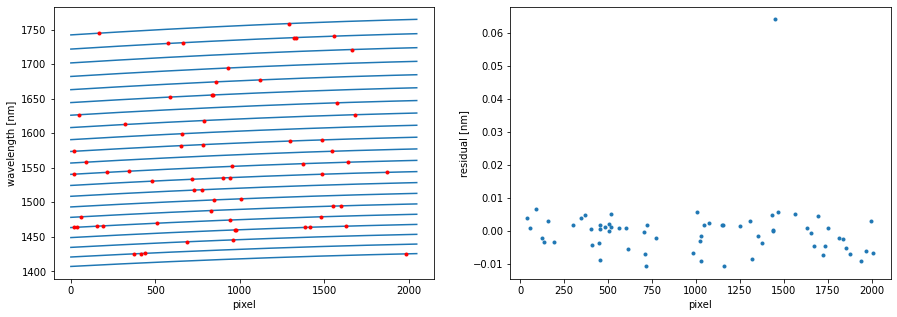

/Users/yuikasagi/git/pyird/src/pyird/spec/wavcal.py:224: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(med[ind_low:ind_upp]) > np.nanpercentile(med[med>0], 80): #CHECK!!


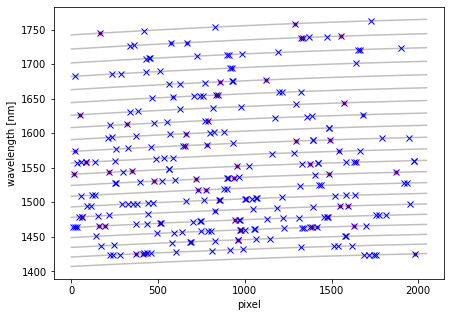

1
0.014507475871876762
2
0.007590313086861726
3
0.0047504505594529916
4
0.00349324738798838
5
0.0024824086250146687
6
0.0016534475932789591
7
0.0012689208320862183
8
0.0009526626913051266


In [9]:
# load ThAr raw image
datadir = basedir/'thar'
anadir = basedir/'reduc'
if flat.band=='h':
    rawtag='IRDAD000'
elif flat.band=='y':
    rawtag='IRDBD000'
#wavelength calibration
thar=irdstream.Stream2D("thar",datadir,anadir,rawtag=rawtag,fitsid=list(range(14632,14732)))
thar.trace = trace_mmf
thar.clean_pattern(trace_mask=trace_mask,extin='', extout='_cp', hotpix_mask=hotpix_mask)
thar.calibrate_wavelength()

The preparation of calibration data is now complete!

## Extract target 1D spectrum

From here, we will extract target spectrum.

In [10]:
### TARGET ###
# Load data
datadir = basedir/'target/'
anadir = basedir/'reduc/'
target = irdstream.Stream2D(
    'targets', datadir, anadir, fitsid=[41510])
if flat.band=='h':
    target.fitsid_increment() # when you use H-band
target.info = True  # show detailed info
target.trace = trace_mmf

fitsid: [41510]


Remove noise pattern on detector by ``clean_pattern``.

In [11]:
# clean pattern
target.clean_pattern(trace_mask=trace_mask,extin='', extout='_cp', hotpix_mask=hotpix_mask)

clean_pattern: output extension= _cp


  0%|                                                                                                                           | 0/1 [00:00<?, ?it/s]/Users/yuikasagi/miniforge3/envs/py39_pip/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


In ``flatten``, each order will be extracted.
The option of ``hotpix_mask`` determines whether hotpixels are masked or not.

In [12]:
# flatten
target.flatten(hotpix_mask=hotpix_mask)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 75.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


flatten (+ hotpix mask): output extension= _hp_m2


If there is set any hotpixel mask, *IRDA000?????_hp.fits* will be created in ``anadir``.

Or, if ``hotpix_mask=None`` (default), *IRDA000?????_fl.fits* will be created in ``anadir``.

Assign wavelength to extracted spectrum.

The option ``extin`` determines whether using the hotpixel masked spectrum (``extin='_hp'``) or not (``extin='fl'`` (default)).

dispcor: output spectrum= w41511_m2.dat


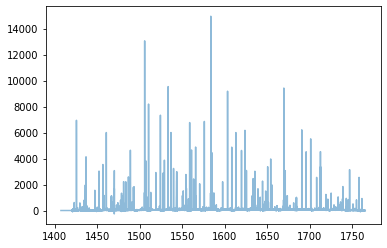

In [13]:
# assign reference spectra & resample
target.dispcor(master_path=thar.anadir,extin='_hp')

*w?????_m?.dat* will be created, whose data format is `$1: Wavelength [nm]`, `$2: Order`, `$ 3 Counts`.

*w?????_m?.dat* reflects the blaze function, so we want to "normalize" the spectra.

The blaze function of each order are created by using Flat spectrum.

By setting ``imcomb=True``, Flat images will be median combined.

  0%|                                                                                                                          | 0/50 [00:00<?, ?it/s]/Users/yuikasagi/miniforge3/envs/py39_pip/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 75.51it/s]


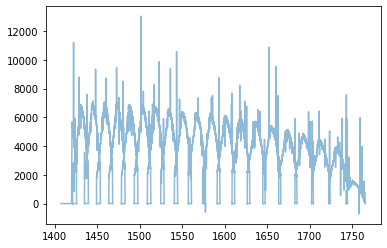

In [14]:
### FLAT (for blaze function) ###
flat.trace = trace_mmf
if flat.band == 'h':
    flat.clean_pattern(trace_mask=trace_mask,extin='', extout='_cp', hotpix_mask=hotpix_mask)
flat.imcomb = True # median combine
flat.flatten()
flat.dispcor(master_path=thar.anadir)

Flat spectrum is now extracted, and *wflat_h_m?.dat* is created.

Then, fit the continuum of the flat spectrum as blaze function and devide target spectrum by them.

normalize1D: output normalized 1D spectrum= nw and ncw41511_m2.dat


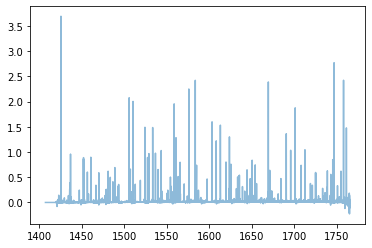

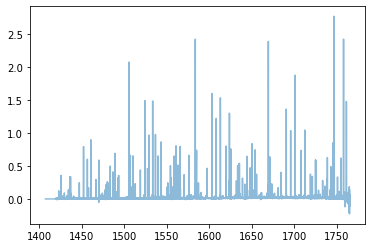

In [15]:
# combine & normalize
target.normalize1D(flatid=flat.streamid,master_path=flat.anadir)

After ``normalize1D``, normalized spectrum (*nw?????_m?.dat*) will be created.
(The data format is the same as "w" spectrum.)

In addition, there will be *ncw?????_m?.dat*, which is the order combined spectrum.

There are overlapping wavelengths at the edge of order, so we "normalize" the spectrum after summing up the flux of that regions to higher signal-to-noise ratio.

The data format is `$1: Wavelength [nm]`, `$2: Counts`.